<a href="https://colab.research.google.com/github/wei-yuan/patent_classification/blob/master/BertFeatureVectorToCPCNumStat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: From The First Claim of Patent to CPC Number Statistics

## Environment Setup

In [103]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

In [104]:
# You will use the AdamW optimizer from tensorflow/models.
!pip install -q tf-models-official==2.7.0

## Import Library

In [105]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Load Pre-Trained Model of BERT from The Following Website

* BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
* Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3

In [106]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


The preprocessing model

In [107]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Load Test Text

In [108]:
claimString = ('A method for controlling an electronic apparatus, '
            + 'the method comprising: receiving image data, '
            + "an artificial intelligence (AI) flag indicating whether AI downscaling is performed by an external server, "
            + "and a filter index from the external server; decoding the image data; "
            + "in response to the AI flag being a first value and the filter index being not null, "
            + "upscaling the decoded image data using a first AI model corresponding to the filter index and providing the upscaled image data for output; "
            + "in response to the AI flag being the first value and the filter index being null, " 
            + "upscaling the decoded image data using a default AI model and providing the upscaled image data for output; " 
            + "and in response to the AI flag being not the first value, providing the decoded image data for output without performing an upscaling process, " 
            + "wherein the image data is obtained by encoding downscaled image data acquired " 
            + "by inputting original image data corresponding to the image data into a second AI model for downscaling original image data, " 
            + "wherein a number of filters of the first AI model is smaller than a number of filters of the second AI model, " 
            + "and wherein the first AI model is a Convolutional Neural Network (CNN).")

claimString = claimString.lower()
print(claimString)

a method for controlling an electronic apparatus, the method comprising: receiving image data, an artificial intelligence (ai) flag indicating whether ai downscaling is performed by an external server, and a filter index from the external server; decoding the image data; in response to the ai flag being a first value and the filter index being not null, upscaling the decoded image data using a first ai model corresponding to the filter index and providing the upscaled image data for output; in response to the ai flag being the first value and the filter index being null, upscaling the decoded image data using a default ai model and providing the upscaled image data for output; and in response to the ai flag being not the first value, providing the decoded image data for output without performing an upscaling process, wherein the image data is obtained by encoding downscaled image data acquired by inputting original image data corresponding to the image data into a second ai model for d

Check The Output Of Test Text

In [109]:
text_test = [claimString]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  1037  4118  2005  9756  2019  4816 14709  1010  1996  4118  9605]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Generate Feature Vector from Test Text

In [110]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [111]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9529026   0.4219553  -0.30200574  0.25369307  0.41103554  0.9101889
  0.98970896 -0.42582595 -0.85301536 -0.6909152  -0.5641822  -0.60431534]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.2696787   0.19009264 -0.5813089  ... -1.064227   -0.33731985
   1.2052773 ]
 [-0.5617293   0.6367726  -0.71991426 ... -0.15618807 -0.8970587
   0.68031204]
 [-0.6592194  -0.33713567 -0.17581698 ... -0.11071557  0.22451127
   0.5562562 ]
 ...
 [-0.3303348   0.18929352 -1.1435108  ... -1.3680383   0.8534971
  -0.40809566]
 [-0.8325043  -0.0549965   0.79068685 ... -0.22852856  0.5220612
  -0.3183328 ]
 [-0.4617275   0.04604169 -1.0418926  ...  0.12435531  0.52764994
   0.78420806]]


Mount Drive

In [112]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Read CSV

In [113]:
import pandas as pd
pd.__version__

'1.3.5'

In [114]:
df = pd.read_csv('gdrive/My Drive/out_sourcing/patent_classification/patent_info.csv')     
df.head()

,patent_name,patent_ID,claim1,abstract,summary,cpc number,claim1_feature_vector,cluster
0,Electronic apparatus and method for upscaling ...,US 20210135378 A1,A method for controlling an electronic apparat...,NaN,NaN,H04N 19/82 (20141101); H04N 19/439 (20141101);...,NaN,NaN
1,Electronic device including antenna module,US 20210135378 A1,"An electronic device, comprising: a housing co...",NaN,NaN,H01Q 1/243 (20130101); H01Q 1/02 (20130101); H...,NaN,NaN
2,Operating method of electronic device for func...,US 20180247065 A1,An electronic device comprising: a housing inc...,NaN,NaN,H04M 1/67 (20130101); G06V 40/197 (20220101); ...,NaN,NaN
3,Display device and method of driving the same ...,US 20210141492 A1,"A display device, comprising: a display panel ...",NaN,NaN,G06F 3/0446 (20190501); G06F 3/0412 (20130101)...,NaN,NaN
4,Touch apparatus and touch detection method the...,US 20210311590 A1,A touch apparatus comprising: a touch panel th...,NaN,NaN,G06F 3/0441 (20190501); G06F 3/0416 (20130101)...,NaN,NaN


# Generate Feature Vector to column claim1_feature_vector

In [115]:
claim1_series = df["claim1"]
claim1_feature_vector_list = list()

for index, value in claim1_series.items():
    text_test = [value]
    text_preprocessed = bert_preprocess_model(text_test)
    bert_results = bert_model(text_preprocessed)
    claim1_feature_vector_list.append(bert_results["pooled_output"].numpy()[0])  # get only 1d vector 

In [116]:
print(f"the number of data in claim1 feature list: {len(claim1_feature_vector_list)}")
length = 5
for index, vector in enumerate(claim1_feature_vector_list, start = 1):
    print(f"the vector size: {vector.shape}")
    print(f"the {index} claim1 feature vector in only {length} digits: {vector[:length]}")

the number of data in claim1 feature list: 15
the vector size: (512,)
the 1 claim1 feature vector in only 5 digits: [ 0.9529026   0.4219553  -0.30200574  0.25369307  0.41103554]
the vector size: (512,)
the 2 claim1 feature vector in only 5 digits: [ 0.95712984  0.28703988 -0.03601776 -0.01548582  0.87454623]
the vector size: (512,)
the 3 claim1 feature vector in only 5 digits: [ 0.959633    0.67156535 -0.16828841  0.29993826  0.836939  ]
the vector size: (512,)
the 4 claim1 feature vector in only 5 digits: [ 0.9653515  -0.65629786 -0.11258493  0.2361003   0.8397746 ]
the vector size: (512,)
the 5 claim1 feature vector in only 5 digits: [ 0.877998   -0.12351528  0.12828426  0.4841077   0.7826838 ]
the vector size: (512,)
the 6 claim1 feature vector in only 5 digits: [ 0.92777634  0.695498   -0.3336455   0.29652742  0.8384483 ]
the vector size: (512,)
the 7 claim1 feature vector in only 5 digits: [ 0.9674787   0.26831323 -0.20602201 -0.01777226  0.6104166 ]
the vector size: (512,)
the 8 

# K-Means Clustering

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

In [118]:
from sklearn.cluster import KMeans

number_of_cluster = 5  # <--- input the number of clusters here
kmeans = KMeans(n_clusters = number_of_cluster)
kmeans.fit(claim1_feature_vector_list)
y_kmeans = kmeans.predict(claim1_feature_vector_list)

In [119]:
print(f"The class number after K-Means: {y_kmeans}")

The class number after K-Means: [1 0 2 0 0 2 1 1 3 4 3 4 0 2 0]


# Dimensional Reduction For High Dimension Vector
The working flow: vector -> PCA -> tSNE

In [120]:
!pip install scprep phate umap-learn

In [121]:
import scprep

In [122]:
# Speed it up by running PCA to 50 dimensions.
data = np.array(claim1_feature_vector_list)
print(f"The data shape: {data.shape}")

# n_components must be between 0 and min(n_samples, n_features)=5
n_samples, n_features = data.shape[0], data.shape[1]
data_pca = scprep.reduce.pca(data, n_components=min(n_samples, n_features), method='dense')

The data shape: (15, 512)


Speed up t-SNE a little further by subsampling

In [123]:
import sklearn.manifold
tsne_op = sklearn.manifold.TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(data)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


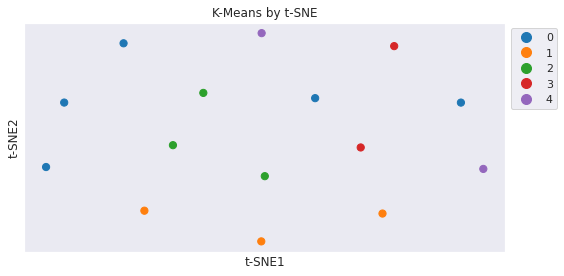

In [124]:
scprep.plot.scatter2d(data_tsne, c=y_kmeans,
                      figsize=(8,4), legend_anchor=(1,1),
                      ticks=False, label_prefix='t-SNE', 
                      title="K-Means by t-SNE")

Update New Series Data To Dataframe

In [125]:
c_series = pd.Series(claim1_feature_vector_list)
print(f"claim 1 feature vector: {c_series}")

claim 1 feature vector: 0     [0.9529026, 0.4219553, -0.30200574, 0.25369307...
1     [0.95712984, 0.28703988, -0.036017757, -0.0154...
2     [0.959633, 0.67156535, -0.16828841, 0.29993826...
3     [0.9653515, -0.65629786, -0.112584926, 0.23610...
4     [0.877998, -0.12351528, 0.12828426, 0.4841077,...
5     [0.92777634, 0.695498, -0.3336455, 0.29652742,...
6     [0.9674787, 0.26831323, -0.20602201, -0.017772...
7     [0.8841269, 0.06563699, -0.44831944, 0.1177656...
8     [0.98434407, -0.13348669, -0.054999013, 0.1469...
9     [0.9935299, 0.7482088, 0.027474264, 0.1860985,...
10    [0.98434407, -0.13348669, -0.054999013, 0.1469...
11    [0.9935299, 0.7482088, 0.027474264, 0.1860985,...
12    [0.9352643, 0.547526, -0.05781861, -0.02595526...
13    [0.88169456, 0.8645572, -0.10003983, -0.042966...
14    [0.97644275, -0.5111096, 0.028287381, 0.380252...
dtype: object


In [126]:
# update claim 1 feature vector
df["claim1_feature_vector"] = c_series

In [127]:
print(df["claim1_feature_vector"])

0     [0.9529026, 0.4219553, -0.30200574, 0.25369307...
1     [0.95712984, 0.28703988, -0.036017757, -0.0154...
2     [0.959633, 0.67156535, -0.16828841, 0.29993826...
3     [0.9653515, -0.65629786, -0.112584926, 0.23610...
4     [0.877998, -0.12351528, 0.12828426, 0.4841077,...
5     [0.92777634, 0.695498, -0.3336455, 0.29652742,...
6     [0.9674787, 0.26831323, -0.20602201, -0.017772...
7     [0.8841269, 0.06563699, -0.44831944, 0.1177656...
8     [0.98434407, -0.13348669, -0.054999013, 0.1469...
9     [0.9935299, 0.7482088, 0.027474264, 0.1860985,...
10    [0.98434407, -0.13348669, -0.054999013, 0.1469...
11    [0.9935299, 0.7482088, 0.027474264, 0.1860985,...
12    [0.9352643, 0.547526, -0.05781861, -0.02595526...
13    [0.88169456, 0.8645572, -0.10003983, -0.042966...
14    [0.97644275, -0.5111096, 0.028287381, 0.380252...
Name: claim1_feature_vector, dtype: object


In [128]:
# update cluster number
df["cluster"] = y_kmeans

In [129]:
df.head(10)

,patent_name,patent_ID,claim1,abstract,summary,cpc number,claim1_feature_vector,cluster
0,Electronic apparatus and method for upscaling ...,US 20210135378 A1,A method for controlling an electronic apparat...,NaN,NaN,H04N 19/82 (20141101); H04N 19/439 (20141101);...,"[0.9529026, 0.4219553, -0.30200574, 0.25369307...",1
1,Electronic device including antenna module,US 20210135378 A1,"An electronic device, comprising: a housing co...",NaN,NaN,H01Q 1/243 (20130101); H01Q 1/02 (20130101); H...,"[0.95712984, 0.28703988, -0.036017757, -0.0154...",0
2,Operating method of electronic device for func...,US 20180247065 A1,An electronic device comprising: a housing inc...,NaN,NaN,H04M 1/67 (20130101); G06V 40/197 (20220101); ...,"[0.959633, 0.67156535, -0.16828841, 0.29993826...",2
3,Display device and method of driving the same ...,US 20210141492 A1,"A display device, comprising: a display panel ...",NaN,NaN,G06F 3/0446 (20190501); G06F 3/0412 (20130101)...,"[0.9653515, -0.65629786, -0.112584926, 0.23610...",0
4,Touch apparatus and touch detection method the...,US 20210311590 A1,A touch apparatus comprising: a touch panel th...,NaN,NaN,G06F 3/0441 (20190501); G06F 3/0416 (20130101)...,"[0.877998, -0.12351528, 0.12828426, 0.4841077,...",0
5,Intelligent data collection and transmission b...,US 20200116814 A1,"A sensing device, comprising: an acoustic sens...",NaN,NaN,G01S 5/0027 (20130101); F42B 12/365 (20130101)...,"[0.92777634, 0.695498, -0.3336455, 0.29652742,...",2
6,Neuromodulation system and method for transiti...,US 20190184168 A1,A neuromodulation system comprising: an extern...,NaN,NaN,A61N 1/36185 (20130101); A61N 1/36071 (2013010...,"[0.9674787, 0.26831323, -0.20602201, -0.017772...",1
7,Blood glucose measurement apparatus and blood ...,US 20190090794 A1,A blood glucose measurement method performed b...,NaN,NaN,A61B 5/14546 (20130101); A61B 5/7282 (20130101...,"[0.8841269, 0.06563699, -0.44831944, 0.1177656...",1
8,Electronic device including electronic compone...,US 20210029275 A1,An electronic device comprising: a housing inc...,NaN,NaN,H04N 5/2258 (20130101); H05K 1/028 (20130101);...,"[0.98434407, -0.13348669, -0.054999013, 0.1469...",3
9,Wireless charging method and system for detect...,US 20210210983 A1,"An electronic device, comprising: a battery; a...",NaN,NaN,H02J 50/80 (20160201); H02J 50/60 (20160201); ...,"[0.9935299, 0.7482088, 0.027474264, 0.1860985,...",4


## Label Classification By Cluster Number

Simplify CPC Number

In [130]:
# select cluster number
cluster_unique = df["cluster"].unique().tolist()
cluster_unique.sort()  # sort in the acsending way
print(f"cluster number: {cluster_unique}")

for cluster_num in cluster_unique:
    print(f"cluster number: {cluster_num}")
    single_cluster = df[df["cluster"] == cluster_num]
    break

cluster number: [0, 1, 2, 3, 4]
cluster number: 0


In [131]:
# check the result of cluster 0
single_cluster.head()

,patent_name,patent_ID,claim1,abstract,summary,cpc number,claim1_feature_vector,cluster
1,Electronic device including antenna module,US 20210135378 A1,"An electronic device, comprising: a housing co...",NaN,NaN,H01Q 1/243 (20130101); H01Q 1/02 (20130101); H...,"[0.95712984, 0.28703988, -0.036017757, -0.0154...",0
3,Display device and method of driving the same ...,US 20210141492 A1,"A display device, comprising: a display panel ...",NaN,NaN,G06F 3/0446 (20190501); G06F 3/0412 (20130101)...,"[0.9653515, -0.65629786, -0.112584926, 0.23610...",0
4,Touch apparatus and touch detection method the...,US 20210311590 A1,A touch apparatus comprising: a touch panel th...,NaN,NaN,G06F 3/0441 (20190501); G06F 3/0416 (20130101)...,"[0.877998, -0.12351528, 0.12828426, 0.4841077,...",0
12,Flexible display panel and display device,NaN,"A display panel comprising: a first region, a ...",NaN,NaN,H05B 33/04 (20130101); G09F 9/30 (20130101); H...,"[0.9352643, 0.547526, -0.05781861, -0.02595526...",0
14,Rollable electronic device including clearance...,NaN,An electronic device comprising: a first housi...,NaN,NaN,G06F 1/1652 (20130101); G06F 1/1624 (20130101)...,"[0.97644275, -0.5111096, 0.028287381, 0.380252...",0


CPC Number Category
* Section: F
* Class: F02
* Sub-class: F02D
* Group: F02D 41
* Sub-Group: F02D 41/02

In [132]:
# read each row data in cpc number
cpc_number_list = single_cluster["cpc number"].tolist()
print(f"Number of element in cpc_number_list: {len(cpc_number_list)}")
print(f"The content of cpc_number_list: {cpc_number_list}")

Number of element in cpc_number_list: 5
The content of cpc_number_list: ['H01Q 1/243 (20130101); H01Q 1/02 (20130101); H01Q 21/062 (20130101); H01Q 1/38 (20130101); H01Q 21/28 (20130101); H01Q 21/065 (20130101); H01Q 1/526 (20130101)', 'G06F 3/0446 (20190501); G06F 3/0412 (20130101); G09G 3/20 (20130101); G06F 3/044 (20130101); G06F 3/0445 (20190501); G06F 3/0416 (20130101); G06F 2203/04106 (20130101); G09G 2300/023 (20130101)', 'G06F 3/0441 (20190501); G06F 3/0416 (20130101); G06F 3/0445 (20190501)', 'H05B 33/04 (20130101); G09F 9/30 (20130101); H01L 51/0097 (20130101); H01L 51/5253 (20130101); G09G 5/003 (20130101); G09G 3/2092 (20130101); H05B 33/14 (20130101); G09F 9/00 (20130101); G09G 5/14 (20130101); H05B 33/02 (20130101); G09G 5/006 (20130101); G09G 2300/0426 (20130101); Y02E 10/549 (20130101); H01L 27/3244 (20130101); G09G 2354/00 (20130101); G09G 2380/02 (20130101)', 'G06F 1/1652 (20130101); G06F 1/1624 (20130101); G06F 1/1656 (20130101)']


In [133]:
def cpc_num_stat(mode: str, cpc_number_list: list, simple_cpc_number_dict: dict):    
    for row in cpc_number_list:
        # split by semi-colon
        row_split_by_semi =  row.split(';')
        for row in row_split_by_semi:        
            cpc_num_set = set()      
            # split by space
            row_split = row.split(' ')        
            row_split_filtered_empty_string = [x for x in row_split if x]
            # to sub-class level
            sub_class = row_split_filtered_empty_string[0]      
            # # to sub-group level
            sub_group = ' '.join(row_split_filtered_empty_string[:2])  # stop until the date information

            if MODE == 'SUB-CLASS':
                data = sub_class
            elif MODE == 'SUB-GROUP':
                data = sub_group

            # add to simple_cpc_number_dict          
            if sub_class not in simple_cpc_number_dict:
                simple_cpc_number_dict[data] = 1
            else:
                simple_cpc_number_dict[data] += 1
    return simple_cpc_number_dict

In [134]:
# switch mode here
MODE = 'SUB-CLASS'
stat_dictionary = dict()
result = cpc_num_stat(MODE, cpc_number_list, stat_dictionary)

In [135]:
print(result)

{'H01Q': 7, 'G06F': 12, 'G09G': 9, 'H05B': 3, 'G09F': 2, 'H01L': 3, 'Y02E': 1}


In [136]:
# switch mode here
MODE = 'SUB-GROUP'
stat_dictionary = dict()
result = cpc_num_stat(MODE, cpc_number_list, stat_dictionary)

In [137]:
print(result)

{'H01Q 1/243': 1, 'H01Q 1/02': 1, 'H01Q 21/062': 1, 'H01Q 1/38': 1, 'H01Q 21/28': 1, 'H01Q 21/065': 1, 'H01Q 1/526': 1, 'G06F 3/0446': 1, 'G06F 3/0412': 1, 'G09G 3/20': 1, 'G06F 3/044': 1, 'G06F 3/0445': 1, 'G06F 3/0416': 1, 'G06F 2203/04106': 1, 'G09G 2300/023': 1, 'G06F 3/0441': 1, 'H05B 33/04': 1, 'G09F 9/30': 1, 'H01L 51/0097': 1, 'H01L 51/5253': 1, 'G09G 5/003': 1, 'G09G 3/2092': 1, 'H05B 33/14': 1, 'G09F 9/00': 1, 'G09G 5/14': 1, 'H05B 33/02': 1, 'G09G 5/006': 1, 'G09G 2300/0426': 1, 'Y02E 10/549': 1, 'H01L 27/3244': 1, 'G09G 2354/00': 1, 'G09G 2380/02': 1, 'G06F 1/1652': 1, 'G06F 1/1624': 1, 'G06F 1/1656': 1}


# iterate all class

In [138]:
# iterate each cluster number
for cluster_num in cluster_unique:
    print(f"cluster number: {cluster_num}")
    single_cluster = df[df["cluster"] == cluster_num]
    cpc_number_list = single_cluster["cpc number"].tolist()
    # switch mode here
    MODE = 'SUB-CLASS'
    stat_dictionary = dict()
    result = cpc_num_stat(MODE, cpc_number_list, stat_dictionary) 
    print(f"CPC number stats in sub-class level: {result}")
    
    result = None
    # switch mode here
    MODE = 'SUB-GROUP'
    stat_dictionary = dict()
    result = cpc_num_stat(MODE, cpc_number_list, stat_dictionary)    
    print(f"CPC number stats in sub-group level: {result}\n")        

cluster number: 0
CPC number stats in sub-class level: {'H01Q': 7, 'G06F': 12, 'G09G': 9, 'H05B': 3, 'G09F': 2, 'H01L': 3, 'Y02E': 1}
CPC number stats in sub-group level: {'H01Q 1/243': 1, 'H01Q 1/02': 1, 'H01Q 21/062': 1, 'H01Q 1/38': 1, 'H01Q 21/28': 1, 'H01Q 21/065': 1, 'H01Q 1/526': 1, 'G06F 3/0446': 1, 'G06F 3/0412': 1, 'G09G 3/20': 1, 'G06F 3/044': 1, 'G06F 3/0445': 1, 'G06F 3/0416': 1, 'G06F 2203/04106': 1, 'G09G 2300/023': 1, 'G06F 3/0441': 1, 'H05B 33/04': 1, 'G09F 9/30': 1, 'H01L 51/0097': 1, 'H01L 51/5253': 1, 'G09G 5/003': 1, 'G09G 3/2092': 1, 'H05B 33/14': 1, 'G09F 9/00': 1, 'G09G 5/14': 1, 'H05B 33/02': 1, 'G09G 5/006': 1, 'G09G 2300/0426': 1, 'Y02E 10/549': 1, 'H01L 27/3244': 1, 'G09G 2354/00': 1, 'G09G 2380/02': 1, 'G06F 1/1652': 1, 'G06F 1/1624': 1, 'G06F 1/1656': 1}

cluster number: 1
CPC number stats in sub-class level: {'H04N': 6, 'G06T': 1, 'A61N': 3, 'A61B': 18, 'G16Z': 1}
CPC number stats in sub-group level: {'H04N 19/82': 1, 'H04N 19/439': 1, 'H04N 19/115': 1, '

In [139]:
# truncate date information

Get the statistics of same CPC number